# MintPy Offset

## Setup

In [2]:
%matplotlib inline
# %matplotlib widget
from osgeo import gdal
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from mintpy.utils import readfile, writefile, utils as ut
from mintpy.objects import ifgramStack
from mintpy import workflow, view, tsview, plot_network, plot_transection, plot_coherence_matrix

## Prep data

In [3]:
cd ~/data/poroa_yearly

/home/fw/data/poroa_yearly


In [4]:
# create separate tif files for each band
files = glob.glob('*.dat')
files.sort()
for fname in files:
    for b, dataset in enumerate(['EWOffset','NSOffset','offsetSNR']):
        fname_out = f'{os.path.splitext(fname)[0]}_{dataset}.tif'
        ds = gdal.Open(fname)
        ds = gdal.Translate(fname_out, ds, bandList = [b+1])
        ds = None

# write mintpy file
files = glob.glob('*EWOffset.tif')+glob.glob('*NSOffset.tif')+glob.glob('*offsetSNR.tif')
files.sort()
lines = [f'{f} {f[9:17]} {f[25:33]}\n' for f in files]
with open('metadata.txt', 'w') as f:
    f.writelines(lines)

In [2]:
cd ~/data/upper_poroa/

/home/fw/data/upper_poroa


## Load Data

In [5]:
!load_data.py -t ../pixeloffset_mintpy/cosicorr.cfg

processor : cosicorr
SAR platform/sensor : unknown from project name "None"
--------------------------------------------------
prepare metadata files for cosicorr products
prep_cosicorr.py /home/fw/data/poroa_yearly/*NSOffset.tif --metadata /home/fw/data/poroa_yearly/metadata.txt
prep_cosicorr.py /home/fw/data/poroa_yearly/*EWOffset.tif --metadata /home/fw/data/poroa_yearly/metadata.txt
prep_cosicorr.py /home/fw/data/poroa_yearly/*offsetSNR.tif --metadata /home/fw/data/poroa_yearly/metadata.txt
--------------------------------------------------
searching interferometric pairs info
input data files:
rangeOffset     : /home/fw/data/poroa_yearly/*EWOffset.tif
azimuthOffset   : /home/fw/data/poroa_yearly/*NSOffset.tif
offsetSNR       : /home/fw/data/poroa_yearly/*offsetSNR.tif
number of rangeOffset     : 15
number of azimuthOffset   : 15
number of offsetSNR       : 15
--------------------------------------------------
searching geometry files info
input data files:
------------------------

## SNR Mask Generation

In [6]:
!temporal_average.py inputs/ifgramStack.h5 -d offsetSNR -o avgSNR.h5

output file: avgSNR.h5
calculate the temporal average of offsetSNR in file inputs/ifgramStack.h5 ...
[==================================================] lines 501/501    0s /     0s
create HDF5 file: avgSNR.h5 with w mode
create dataset /offsetSNR of float32    in size of (501, 501)           with compression=None
finished writing to avgSNR.h5
time used: 00 mins 0.1 secs



(0.0, 50000.0)

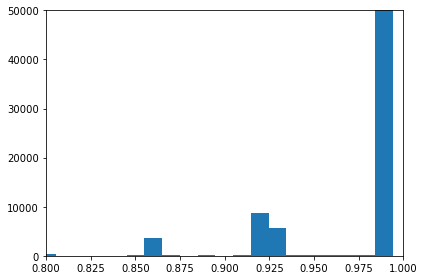

In [7]:
data, atr = readfile.read('avgSNR.h5')

fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.hist(data.flatten(),100)
ax.set_xlim(0.8,1)
ax.set_ylim(0.0,50000.0)

input offsetSNR file: avgSNR.h5
read avgSNR.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.8
create HDF5 file: maskSNR.h5 with w mode
create dataset /mask of bool       in size of (501, 501)           with compression=None
finished writing to maskSNR.h5
time used: 00 mins 0.0 secs.
view.py maskSNR.h5 --noverbose


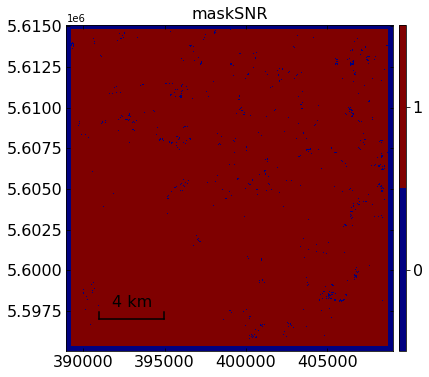

In [8]:
!generate_mask.py avgSNR.h5 -m 0.8 -o maskSNR.h5
view.main('maskSNR.h5 --noverbose'.split())

## Median Removal

In [9]:
mean_az, date12_list = ut.spatial_average('inputs/ifgramStack.h5', datasetName='azimuthOffset', maskFile='maskSNR.h5', saveList=True)
mean_rg, date12_list = ut.spatial_average('inputs/ifgramStack.h5', datasetName='rangeOffset', maskFile='maskSNR.h5', saveList=True)

az, atr = readfile.read('inputs/ifgramStack.h5', datasetName='azimuthOffset')
rg, atr = readfile.read('inputs/ifgramStack.h5', datasetName='rangeOffset')
snr, atr = readfile.read('inputs/ifgramStack.h5', datasetName='offsetSNR')

for i,m in enumerate(mean_az):
    az[i] -= m

for i,m in enumerate(mean_rg):
    rg[i] -= m

calculating spatial mean of azimuthOffset in file inputs/ifgramStack.h5 ...
read mask from file: maskSNR.h5
[==================================================] 15/15    0s /     0s 
write average value in space into text file: azimuthOffsetSpatialAvg.txt
calculating spatial mean of rangeOffset in file inputs/ifgramStack.h5 ...
read mask from file: maskSNR.h5
[==================================================] 15/15    0s /     0s 
write average value in space into text file: rangeOffsetSpatialAvg.txt


In [10]:
datasetDict = {'rangeOffset':rg, 'azimuthOffset':az, 'offsetSNR':snr}
writefile.write(datasetDict,out_file='inputs/ifgramStack_median.h5',ref_file='inputs/ifgramStack.h5')

create HDF5 file: inputs/ifgramStack_median.h5 with w mode
create dataset /rangeOffset   of float32    in size of (15, 501, 501)       with compression=None
create dataset /azimuthOffset of float32    in size of (15, 501, 501)       with compression=None
create dataset /offsetSNR     of float32    in size of (15, 501, 501)       with compression=None
create dataset /bperp         of float32    in size of (15,)      with compression=None
create dataset /date          of |S8        in size of (15, 2)    with compression=None
create dataset /dropIfgram    of bool       in size of (15,)      with compression=None
finished writing to inputs/ifgramStack_median.h5


'inputs/ifgramStack_median.h5'

## Double Difference

In [94]:
!spatial_filter.py inputs/ifgramStack.h5 azimuthOffset rangeOffset -o inputs/ifgramStackDD.h5  -f double_difference -p 1 12

filtering ifgramStack file: inputs/ifgramStack.h5 using double_difference filter with local/regional kernel sizes of 1/12
filtering azimuthOffset from ifgramStack.h5  15/15 ...
filtering rangeOffset   from ifgramStack.h5  15/15 ...
create HDF5 file: inputs/ifgramStackDD.h5 with w mode
create dataset /offsetSNR     of float32    in size of (15, 501, 501)       with compression=None
create dataset /azimuthOffset of float32    in size of (15, 501, 501)       with compression=None
create dataset /rangeOffset   of float32    in size of (15, 501, 501)       with compression=None
create dataset /bperp         of float32    in size of (15,)      with compression=None
create dataset /date          of |S8        in size of (15, 2)    with compression=None
create dataset /dropIfgram    of bool       in size of (15,)      with compression=None
finished writing to inputs/ifgramStackDD.h5
Done.


## Spatial Average

In [99]:
!spatial_filter.py inputs/ifgramStack.h5 azimuthOffset rangeOffset -o inputs/ifgramStackLocal.h5 -f lowpass_avg -p 12

filtering ifgramStack file: inputs/ifgramStack.h5 using lowpass_avg filter with kernel size of 12
filtering azimuthOffset from ifgramStack.h5  15/15 ...
filtering rangeOffset   from ifgramStack.h5  15/15 ...
create HDF5 file: inputs/ifgramStackLocal.h5 with w mode
create dataset /offsetSNR     of float32    in size of (15, 501, 501)       with compression=None
create dataset /azimuthOffset of float32    in size of (15, 501, 501)       with compression=None
create dataset /rangeOffset   of float32    in size of (15, 501, 501)       with compression=None
create dataset /bperp         of float32    in size of (15,)      with compression=None
create dataset /date          of |S8        in size of (15, 2)    with compression=None
create dataset /dropIfgram    of bool       in size of (15,)      with compression=None
finished writing to inputs/ifgramStackLocal.h5
Done.


## Inversion

In [11]:
# !ifgram_inversion.py inputs/ifgramStack.h5 -i rangeOffset -w no --md offsetSNR --mt 0.98 -o timeseriesRg.h5 residualInvRg.h5 numInvOffsetRg.h5
# !ifgram_inversion.py inputs/ifgramStack.h5 -i azimuthOffset -w no --md offsetSNR --mt 0.98 -o timeseriesAz.h5 residualInvAz.h5 numInvOffsetAz.h5

!ifgram_inversion.py inputs/ifgramStack_median.h5 -i rangeOffset -w no --md offsetSNR --mt 0.98 -o timeseriesRg.h5 residualInvRg.h5 numInvOffsetRg.h5
!ifgram_inversion.py inputs/ifgramStack_median.h5 -i azimuthOffset -w no --md offsetSNR --mt 0.98 -o timeseriesAz.h5 residualInvAz.h5 numInvOffsetAz.h5

# !ifgram_inversion.py inputs/ifgramStackLocal.h5 -i rangeOffset -w no --md offsetSNR --mt 0.98 -o timeseriesRg.h5 residualInvRg.h5 numInvOffsetRg.h5
# !ifgram_inversion.py inputs/ifgramStackLocal.h5 -i azimuthOffset -w no --md offsetSNR --mt 0.98 -o timeseriesAz.h5 residualInvAz.h5 numInvOffsetAz.h5

save the original settings of ['OMP_NUM_THREADS', 'OPENBLAS_NUM_THREADS', 'MKL_NUM_THREADS', 'NUMEXPR_NUM_THREADS', 'VECLIB_MAXIMUM_THREADS']
set OMP_NUM_THREADS = 1
set OPENBLAS_NUM_THREADS = 1
set MKL_NUM_THREADS = 1
set NUMEXPR_NUM_THREADS = 1
set VECLIB_MAXIMUM_THREADS = 1
skip checking reference pixel info - This is for offset and testing ONLY.
-------------------------------------------------------------------------------
least-squares solution with L2 min-norm on: deformation velocity
minimum redundancy: 1.0
weight function: no
mask out pixels with: offsetSNR < 0.98
-------------------------------------------------------------------------------
number of interferograms: 15
number of acquisitions  : 6
number of lines   : 501
number of columns : 501
--------------------------------------------------
create HDF5 file: timeseriesRg.h5 with w mode
create dataset  : date       of |S8                       in size of (6,)                 with compression = None
create dataset  : bperp 

## timeseries2velocity

In [12]:
!timeseries2velocity.py timeseriesAz.h5 --bootstrap -o velocityAz.h5
!timeseries2velocity.py timeseriesRg.h5 --bootstrap -o velocityRg.h5

bootstrapping is turned ON.
open timeseries file: timeseriesAz.h5
--------------------------------------------------
dates from input file: 6
['20160206', '20161122', '20171122', '20190225', '20191122', '20210130']
--------------------------------------------------
using all dates to calculate the velocity
--------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    step       : []
    exp        : {}
    log        : {}
add/update the following configuration metadata:
['startDate', 'endDate', 'excludeDate', 'bootstrap', 'bootstrapCount']
--------------------------------------------------
create HDF5 file: velocityAz.h5 with w mode
create dataset  : velocity    of <class 'numpy.float32'>   in size of (501, 501)           with compression = None
create dataset  : velocityStd of <class 'numpy.float32'>   in size of (501, 501)           with compression = None
add /velocity    attribute:

## To GeoTIFF

In [19]:
#need to change line to 32760
# !save_gdal.py velocityAz.h5 -o velocityAz.tif
# !save_gdal.py velocityRg.h5 -o velocityRg.tif

read metadata from file: velocityAz.h5
read data     from file: velocityAz.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 301, 226
raster transform info: (398700.0, 40.0, 0, 5604370.0, 0, -40.0)
write data to raster band
set projectection as: EPSG 4326
finished writing to /home/fw/data/upper_poroa/velocityAz.tif
read metadata from file: velocityRg.h5
read data     from file: velocityRg.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 301, 226
raster transform info: (398700.0, 40.0, 0, 5604370.0, 0, -40.0)
write data to raster band
set projectection as: EPSG 4326
finished writing to /home/fw/data/upper_poroa/velocityRg.tif


## Move

In [21]:
!cp velocityAz.tif /mnt/i/sentinel2/upper/velocityAz.tif
!cp velocityRg.tif /mnt/i/sentinel2/upper/velocityRg.tif

## Viewing

In [103]:
%matplotlib widget
import matplotlib.pyplot as plt

In [107]:
# view.main('median/velocityAz.h5 --noverbose'.split())

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt

[ 0. nan]


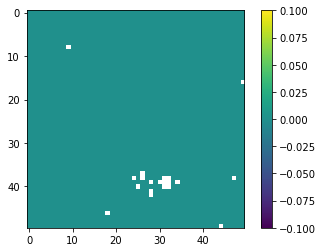

In [157]:
# !info.py inputs/ifgramStack.h5
# help(readfile.read)
s = slice(200,250), slice(200,250)
fname = '../cosicorr_20161122T221602_20190225T221559_EWOffset.tif'

# mintpy_data = readfile.read_gdal(fname)

mintpy_data, atr = readfile.read('inputs/ifgramStack.h5', datasetName='rangeOffset-20161122_20190225')

ds = gdal.Open(fname)
gdal_data = ds.GetRasterBand(1).ReadAsArray()
ds = None

matches = gdal_data - mintpy_data
print(np.unique(matches))
fig, ax = plt.subplots()
# im = ax.imshow(gdal_data[s])
# im = ax.imshow(mintpy_data[s])
im = ax.imshow(matches[s])
ax.figure.colorbar(im)

In [58]:
!ifgram_inversion.py inputs/ifgramStack.h5 -i rangeOffset -w no --md offsetSNR --mt 5
# ifgram_inversion.py inputs/ifgramStack.h5 -i azimuthOffset -w no -m waterMask.h5 --md offsetSNR --mt 5

skip checking reference pixel info - This is for offset and testing ONLY.
-------------------------------------------------------------------------------
least-squares solution with L2 min-norm on: deformation velocity
minimum redundancy: 1.0
weight function: no
mask out pixels with: offsetSNR < 5.0
-------------------------------------------------------------------------------
number of interferograms: 15
number of acquisitions  : 6
number of lines   : 501
number of columns : 501
--------------------------------------------------
create HDF5 file: timeseriesRg.h5 with w mode
create dataset  : date       of |S8                       in size of (6,)                 with compression = None
create dataset  : bperp      of <class 'numpy.float32'>   in size of (6,)                 with compression = None
create dataset  : timeseries of <class 'numpy.float32'>   in size of (6, 501, 501)        with compression = None
close  HDF5 file: timeseriesRg.h5
-----------------------------------------